# Projet 9 – Amélioration de la segmentation pour la conduite autonome

Bienvenue dans ce notebook consacré au Projet 9 du parcours Engineer AI.

## Objectif
Comparer un modèle récents de **segmentation d’images** (Segformer) avec un **modèle baseline** (U-Net EfficientNetB3) sur le dataset **Cityscapes**, dans un contexte de vision par ordinateur pour véhicules autonomes.

L'objectif final est d'identifier un modèle plus performant à intégrer dans une API métier.

---

In [1]:
############################################
# Importation des librairies nécessaires
############################################

from pathlib import Path
from fonctions import *
from config import DATA_DIR
# from transformers import OneFormerForSemanticSegmentation
from transformers import Mask2FormerForUniversalSegmentation



import torch
import matplotlib.pyplot as plt
import pandas as pd
import timm
import segmentation_models_pytorch as smp

Segmentation Models: using `keras` framework.


In [2]:
##############################################
# Vérification du GPU
##############################################

print("Torch version:", torch.__version__)
print("CUDA disponible :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Carte GPU :", torch.cuda.get_device_name(0))

Torch version: 2.2.0+cu118
CUDA disponible : True
Carte GPU : NVIDIA GeForce RTX 3080 Ti


## Structure du dossier `data/`

Le dossier `data/` contient les images et annotations du dataset **Cityscapes**, utilisé pour entraîner nos modèles de segmentation.

Nous allons charger et visualiser la structure pour vérifier que les données sont correctement en place.

In [3]:
view_folder(DATA_DIR)

|-- gtFine
    |-- test
    |-- train
    |-- val
|-- leftImg8bit
    |-- test
    |-- train
    |-- val


## 🔍 Chargement d’un batch d’images avec PyTorch

Nous testons ici la fonction `charger_donnees_cityscapes()` pour vérifier que :
- Les images sont bien chargées et redimensionnées
- Les masques sont remappés vers les 8 classes principales
- Le `DataLoader` fonctionne correctement

Nous affichons le premier batch pour valider visuellement le prétraitement.

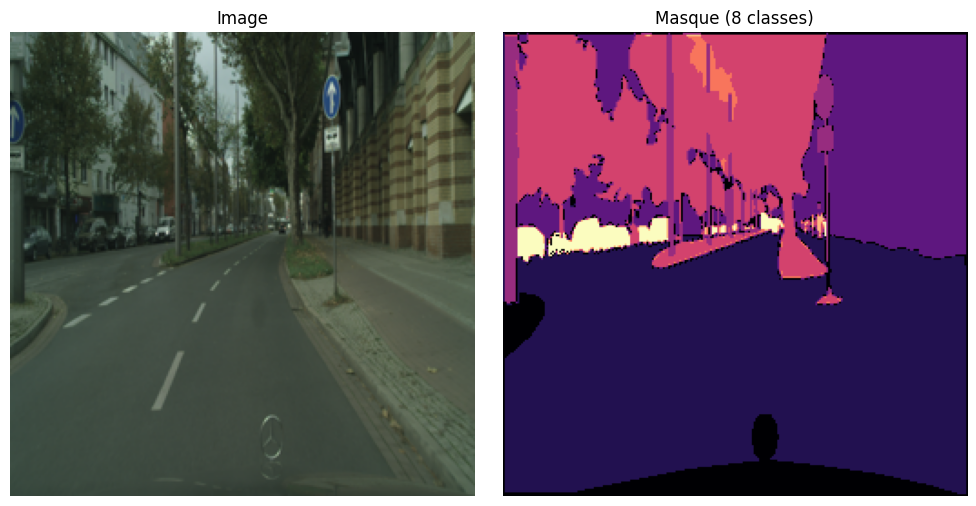

In [4]:
train_loader, val_loader = charger_donnees_cityscapes(DATA_DIR, batch_size=2)

images, masks = next(iter(train_loader))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(masks[0].cpu().numpy(), cmap="magma")
plt.title("Masque (8 classes)")
plt.axis("off")

plt.tight_layout()
plt.show()

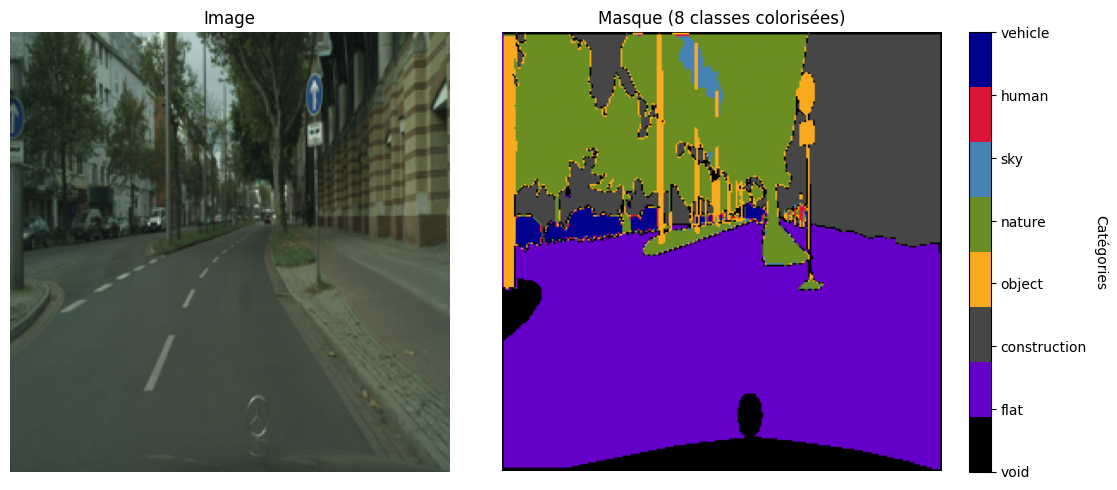

In [5]:
afficher_image_et_masque(images[0], masks[0])

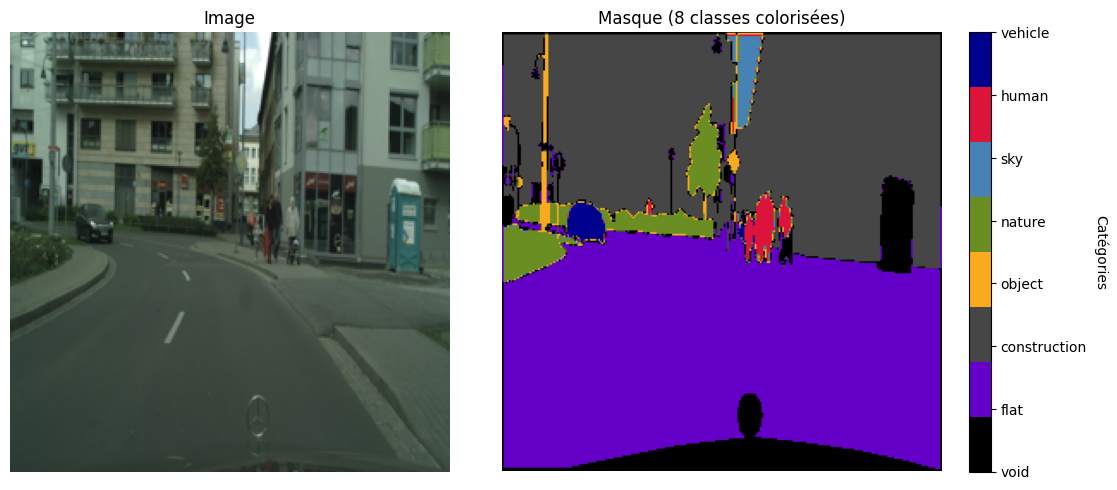

In [6]:
train_loader, val_loader = charger_donnees_cityscapes(DATA_DIR, batch_size=16)
images, masks = next(iter(train_loader))
afficher_image_et_masque(images[0], masks[0])

In [7]:
# Vérifier les valeurs uniques dans un seul masque
print("Valeurs uniques dans masks[0] :", torch.unique(masks[0]))

# Optionnel : vérifier les valeurs dans tout le batch
valeurs_uniques_batch = torch.unique(masks)
print("Valeurs uniques dans tout le batch :", valeurs_uniques_batch)

Valeurs uniques dans masks[0] : tensor([0, 1, 2, 3, 4, 5, 6, 7])
Valeurs uniques dans tout le batch : tensor([0, 1, 2, 3, 4, 5, 6, 7])


🕒 Temps total d'entraînement : 368.37 minutes


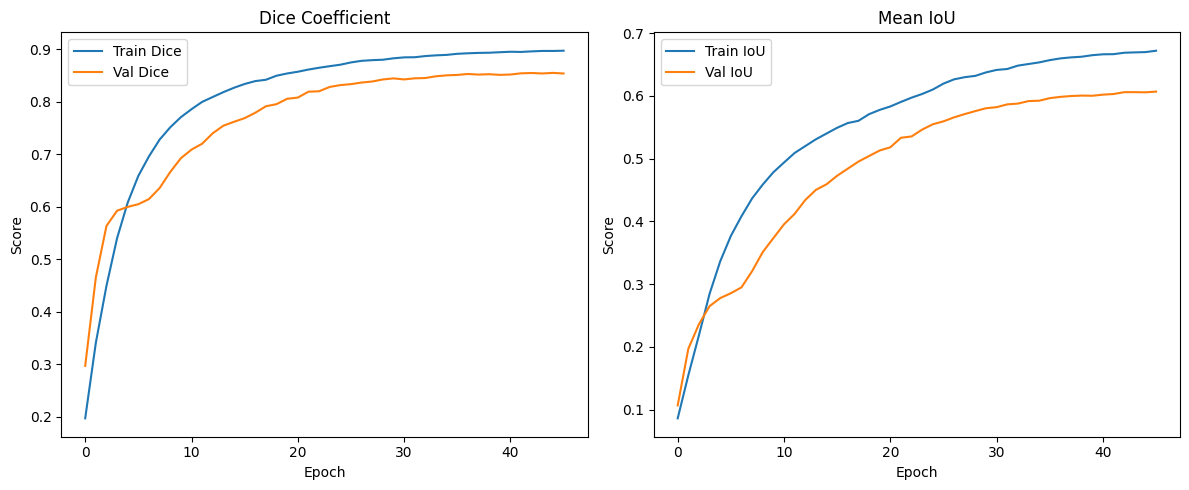

In [8]:
csv_path = Path("../resultats_modeles/efficientnetb3_20250312_173536.csv")
df_metrics = pd.read_csv(csv_path)

# Conversion du temps total d'entraînement en minutes (si dispo)
if "temps_total_sec" in df_metrics.columns:
    total_time_sec = df_metrics["temps_total_sec"].iloc[-1]
    total_time_min = total_time_sec / 60
    print(f"🕒 Temps total d'entraînement : {total_time_min:.2f} minutes")

plt.figure(figsize=(12, 5))

# Courbe du Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(df_metrics["dice_coef"], label="Train Dice")
plt.plot(df_metrics["val_dice_coef"], label="Val Dice")
plt.title("Dice Coefficient")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

# Courbe du Mean IoU
plt.subplot(1, 2, 2)
plt.plot(df_metrics["mean_iou"], label="Train IoU")
plt.plot(df_metrics["val_mean_iou"], label="Val IoU")
plt.title("Mean IoU")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
from glob import glob

# Chemins globaux
image_dir = DATA_DIR / "leftImg8bit"
mask_dir = DATA_DIR / "gtFine"

# Chargement des chemins d’images et masques (train / val uniquement)
train_input_img_paths = sorted(glob(str(image_dir / "train/*/*.png")))
val_input_img_paths = sorted(glob(str(image_dir / "val/*/*.png")))

train_label_ids_img_paths = sorted(glob(str(mask_dir / "train/*/*labelIds.png")))
val_label_ids_img_paths = sorted(glob(str(mask_dir / "val/*/*labelIds.png")))

print(f"🖼️ Total train images : {len(train_input_img_paths)}")
print(f"🖼️ Total val images   : {len(val_input_img_paths)}")

🖼️ Total train images : 2975
🖼️ Total val images   : 500


In [10]:
from glob import glob
from pathlib import Path
from torch.utils.data import DataLoader
from fonctions import remap_classes  # déjà défini dans ton projet
from PIL import Image
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

############################################
# Définition du Dataset avec Albumentations
############################################

class CityscapesSegformerDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_paths,
        mask_paths,
        image_size=(256, 256),
        mode="train",  # "train" ou "val"
        augmentation_ratio=1.0
    ):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.mode = mode
        self.augmentation_ratio = augmentation_ratio

        self.augment = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.Rotate(limit=15, p=0.2),
            A.RandomScale(scale_limit=0.1, p=0.2),
            A.Resize(height=image_size[0], width=image_size[1], interpolation=1),
        ])

        self.to_tensor = A.Compose([
            A.Resize(height=image_size[0], width=image_size[1], interpolation=1),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        mask = remap_classes(mask)

        # Augmentation conditionnelle
        if self.mode == "train" and np.random.rand() < self.augmentation_ratio:
            augmented = self.augment(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        final = self.to_tensor(image=image, mask=mask)
        image_tensor = final["image"]
        mask_tensor = final["mask"].long()

        return image_tensor, mask_tensor

In [11]:
"""# Sélection d'un sous-ensemble du jeu de données pour l'entraînement rapide
train_img_paths = train_input_img_paths[:200]
train_mask_paths = train_label_ids_img_paths[:200]

val_img_paths = val_input_img_paths[:50]
val_mask_paths = val_label_ids_img_paths[:50]

# Générateurs pour l'entraînement et la validation
train_generator = DataGenerator(
    image_paths=train_img_paths,
    mask_paths=train_mask_paths,
    batch_size=16,
    image_size=(256, 256),
    augmentation_ratio=0.5,
    num_classes=8
)

val_generator = DataGenerator(
    image_paths=val_img_paths,
    mask_paths=val_mask_paths,
    batch_size=16,
    image_size=(256, 256),
    augmentation_ratio=0,
    num_classes=8
)

print(f"📂 Dataset préparé : {len(train_img_paths)} images pour l'entraînement, {len(val_img_paths)} pour la validation, similaire au Projet 8")"""

'# Sélection d\'un sous-ensemble du jeu de données pour l\'entraînement rapide\ntrain_img_paths = train_input_img_paths[:200]\ntrain_mask_paths = train_label_ids_img_paths[:200]\n\nval_img_paths = val_input_img_paths[:50]\nval_mask_paths = val_label_ids_img_paths[:50]\n\n# Générateurs pour l\'entraînement et la validation\ntrain_generator = DataGenerator(\n    image_paths=train_img_paths,\n    mask_paths=train_mask_paths,\n    batch_size=16,\n    image_size=(256, 256),\n    augmentation_ratio=0.5,\n    num_classes=8\n)\n\nval_generator = DataGenerator(\n    image_paths=val_img_paths,\n    mask_paths=val_mask_paths,\n    batch_size=16,\n    image_size=(256, 256),\n    augmentation_ratio=0,\n    num_classes=8\n)\n\nprint(f"📂 Dataset préparé : {len(train_img_paths)} images pour l\'entraînement, {len(val_img_paths)} pour la validation, similaire au Projet 8")'

In [12]:
"""DATA_DIR = Path("../data")
image_dir = DATA_DIR / "leftImg8bit"
mask_dir  = DATA_DIR / "gtFine"

train_input_img_paths = sorted(glob(str(image_dir / "train/*/*.png")))
train_label_ids_img_paths = sorted(glob(str(mask_dir / "train/*/*labelIds.png")))

val_input_img_paths = sorted(glob(str(image_dir / "val/*/*.png")))
val_label_ids_img_paths = sorted(glob(str(mask_dir / "val/*/*labelIds.png")))

# Réduction du dataset (comme avec DataGenerator)
train_img_paths = train_input_img_paths[:2000]
train_mask_paths = train_label_ids_img_paths[:2000]

val_img_paths = val_input_img_paths[:500]
val_mask_paths = val_label_ids_img_paths[:500]

print(f"📂 Dataset préparé : {len(train_img_paths)} images pour l'entraînement, {len(val_img_paths)} pour la validation, similaire au Projet 8")"""

'DATA_DIR = Path("../data")\nimage_dir = DATA_DIR / "leftImg8bit"\nmask_dir  = DATA_DIR / "gtFine"\n\ntrain_input_img_paths = sorted(glob(str(image_dir / "train/*/*.png")))\ntrain_label_ids_img_paths = sorted(glob(str(mask_dir / "train/*/*labelIds.png")))\n\nval_input_img_paths = sorted(glob(str(image_dir / "val/*/*.png")))\nval_label_ids_img_paths = sorted(glob(str(mask_dir / "val/*/*labelIds.png")))\n\n# Réduction du dataset (comme avec DataGenerator)\ntrain_img_paths = train_input_img_paths[:2000]\ntrain_mask_paths = train_label_ids_img_paths[:2000]\n\nval_img_paths = val_input_img_paths[:500]\nval_mask_paths = val_label_ids_img_paths[:500]\n\nprint(f"📂 Dataset préparé : {len(train_img_paths)} images pour l\'entraînement, {len(val_img_paths)} pour la validation, similaire au Projet 8")'

In [13]:
DATA_DIR = Path("../data")
image_dir = DATA_DIR / "leftImg8bit"
mask_dir  = DATA_DIR / "gtFine"

# Récupération de tous les chemins d’images et masques
train_input_img_paths = sorted(glob(str(image_dir / "train/*/*.png")))
train_label_ids_img_paths = sorted(glob(str(mask_dir  / "train/*/*labelIds.png")))

val_input_img_paths = sorted(glob(str(image_dir / "val/*/*.png")))
val_label_ids_img_paths = sorted(glob(str(mask_dir  / "val/*/*labelIds.png")))

# Réduction du dataset pour l’exemple
train_img_paths = train_input_img_paths[:2000]
train_mask_paths = train_label_ids_img_paths[:2000]

val_img_paths = val_input_img_paths[:500]
val_mask_paths = val_label_ids_img_paths[:500]

# Construire un DataFrame pour chaque split
df_train = pd.DataFrame({
    "image_path": train_img_paths,
    "mask_path": train_mask_paths
})
df_train["split"] = "train"

df_val = pd.DataFrame({
    "image_path": val_img_paths,
    "mask_path": val_mask_paths
})
df_val["split"] = "val"

# Concaténer train & val
df_all = pd.concat([df_train, df_val], ignore_index=True)

# Aperçu
print(df_all.head())

# Sauvegarder en CSV
df_all.to_csv("cityscapes_subset.csv", index=False)

                                          image_path  \
0  ..\data\leftImg8bit\train\aachen\aachen_000000...   
1  ..\data\leftImg8bit\train\aachen\aachen_000001...   
2  ..\data\leftImg8bit\train\aachen\aachen_000002...   
3  ..\data\leftImg8bit\train\aachen\aachen_000003...   
4  ..\data\leftImg8bit\train\aachen\aachen_000004...   

                                           mask_path  split  
0  ..\data\gtFine\train\aachen\aachen_000000_0000...  train  
1  ..\data\gtFine\train\aachen\aachen_000001_0000...  train  
2  ..\data\gtFine\train\aachen\aachen_000002_0000...  train  
3  ..\data\gtFine\train\aachen\aachen_000003_0000...  train  
4  ..\data\gtFine\train\aachen\aachen_000004_0000...  train  


In [14]:
# Instanciation des datasets avec les mêmes options que DataGenerator
train_dataset = CityscapesSegformerDataset(
    image_paths=train_img_paths,
    mask_paths=train_mask_paths,
    image_size=(256, 256),
    mode="train",
    augmentation_ratio=0.5
)

val_dataset = CityscapesSegformerDataset(
    image_paths=val_img_paths,
    mask_paths=val_mask_paths,
    image_size=(256, 256),
    mode="val",
    augmentation_ratio=0  # pas d’augmentation
)

# Création des DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"📂 Entraînement : {len(train_loader)} batches de {len(train_dataset)} images")
print(f"📂 Validation   : {len(val_loader)} batches de {len(val_dataset)} images")

📂 Entraînement : 125 batches de 2000 images
📂 Validation   : 32 batches de 500 images


In [15]:
"""# Mini DataSet de Test

from torch.utils.data import DataLoader

# Création du dataset train
train_dataset = MiniCityscapesDataset(train_img_paths, train_mask_paths, image_size=(256,256))
val_dataset   = MiniCityscapesDataset(val_img_paths,   val_mask_paths,   image_size=(256,256))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=4, pin_memory=True)"""

'# Mini DataSet de Test\n\nfrom torch.utils.data import DataLoader\n\n# Création du dataset train\ntrain_dataset = MiniCityscapesDataset(train_img_paths, train_mask_paths, image_size=(256,256))\nval_dataset   = MiniCityscapesDataset(val_img_paths,   val_mask_paths,   image_size=(256,256))\n\ntrain_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=4, pin_memory=True)\nval_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=4, pin_memory=True)'

In [16]:
model_segformer = charger_segformer(num_classes=8)

entrainer_model_pytorch(
    model=model_segformer,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="segformer_b5",
    epochs=50,
    lr=1e-4
)

# Affichage des prédictions sur le jeu de validation
# show_predictions(model_segformer, val_dataset, num_images=3)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([8, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[Epoch 1/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.14s/it]


📉 Epoch 1 | Train Loss: 0.8284 | Val Loss: 0.5285 | Train Dice: 0.5884 | Val Dice: 0.6148 | Train IoU: 0.4953 | Val IoU: 0.5279 | Time: 196.0s | GPU: 6388.4 MB


[Epoch 2/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 2 | Train Loss: 0.4488 | Val Loss: 0.4202 | Train Dice: 0.6649 | Val Dice: 0.6832 | Train IoU: 0.5770 | Val IoU: 0.5917 | Time: 199.5s | GPU: 6388.4 MB


[Epoch 3/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 3 | Train Loss: 0.3672 | Val Loss: 0.3769 | Train Dice: 0.7155 | Val Dice: 0.7003 | Train IoU: 0.6269 | Val IoU: 0.6088 | Time: 194.0s | GPU: 6388.4 MB


[Epoch 4/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 4 | Train Loss: 0.3179 | Val Loss: 0.3487 | Train Dice: 0.7497 | Val Dice: 0.7333 | Train IoU: 0.6599 | Val IoU: 0.6368 | Time: 196.4s | GPU: 6388.4 MB


[Epoch 5/50] Val: 100%|██████████| 32/32 [00:49<00:00,  1.55s/it]


📉 Epoch 5 | Train Loss: 0.2910 | Val Loss: 0.3454 | Train Dice: 0.7745 | Val Dice: 0.7526 | Train IoU: 0.6815 | Val IoU: 0.6537 | Time: 213.0s | GPU: 6388.4 MB


[Epoch 6/50] Val: 100%|██████████| 32/32 [00:45<00:00,  1.44s/it]


📉 Epoch 6 | Train Loss: 0.2732 | Val Loss: 0.3479 | Train Dice: 0.7898 | Val Dice: 0.7595 | Train IoU: 0.6965 | Val IoU: 0.6593 | Time: 251.3s | GPU: 6388.4 MB


[Epoch 7/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 7 | Train Loss: 0.2545 | Val Loss: 0.3303 | Train Dice: 0.8024 | Val Dice: 0.7688 | Train IoU: 0.7103 | Val IoU: 0.6682 | Time: 194.6s | GPU: 6388.4 MB


[Epoch 8/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 8 | Train Loss: 0.2424 | Val Loss: 0.3529 | Train Dice: 0.8097 | Val Dice: 0.7685 | Train IoU: 0.7184 | Val IoU: 0.6697 | Time: 193.7s | GPU: 6388.4 MB


[Epoch 9/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 9 | Train Loss: 0.2358 | Val Loss: 0.3451 | Train Dice: 0.8135 | Val Dice: 0.7726 | Train IoU: 0.7230 | Val IoU: 0.6720 | Time: 197.1s | GPU: 6388.4 MB


[Epoch 10/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 10 | Train Loss: 0.2272 | Val Loss: 0.3564 | Train Dice: 0.8193 | Val Dice: 0.7729 | Train IoU: 0.7294 | Val IoU: 0.6723 | Time: 195.2s | GPU: 6388.4 MB


[Epoch 11/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 11 | Train Loss: 0.2182 | Val Loss: 0.3338 | Train Dice: 0.8249 | Val Dice: 0.7763 | Train IoU: 0.7361 | Val IoU: 0.6772 | Time: 196.6s | GPU: 6388.4 MB


[Epoch 12/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 12 | Train Loss: 0.2108 | Val Loss: 0.3504 | Train Dice: 0.8293 | Val Dice: 0.7766 | Train IoU: 0.7419 | Val IoU: 0.6774 | Time: 194.3s | GPU: 6388.4 MB


[Epoch 13/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 13 | Train Loss: 0.2072 | Val Loss: 0.3422 | Train Dice: 0.8308 | Val Dice: 0.7806 | Train IoU: 0.7436 | Val IoU: 0.6809 | Time: 193.7s | GPU: 6388.4 MB


[Epoch 14/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 14 | Train Loss: 0.2006 | Val Loss: 0.3370 | Train Dice: 0.8361 | Val Dice: 0.7814 | Train IoU: 0.7499 | Val IoU: 0.6821 | Time: 194.3s | GPU: 6388.4 MB


[Epoch 15/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 15 | Train Loss: 0.1986 | Val Loss: 0.3366 | Train Dice: 0.8359 | Val Dice: 0.7825 | Train IoU: 0.7501 | Val IoU: 0.6832 | Time: 194.5s | GPU: 6388.4 MB


[Epoch 16/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 16 | Train Loss: 0.1973 | Val Loss: 0.3401 | Train Dice: 0.8372 | Val Dice: 0.7827 | Train IoU: 0.7518 | Val IoU: 0.6833 | Time: 193.9s | GPU: 6388.4 MB


[Epoch 17/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 17 | Train Loss: 0.1945 | Val Loss: 0.3389 | Train Dice: 0.8388 | Val Dice: 0.7821 | Train IoU: 0.7536 | Val IoU: 0.6834 | Time: 195.6s | GPU: 6388.4 MB


[Epoch 18/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 18 | Train Loss: 0.1932 | Val Loss: 0.3407 | Train Dice: 0.8389 | Val Dice: 0.7828 | Train IoU: 0.7540 | Val IoU: 0.6837 | Time: 193.2s | GPU: 6388.4 MB


[Epoch 19/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.15s/it]


📉 Epoch 19 | Train Loss: 0.1922 | Val Loss: 0.3430 | Train Dice: 0.8393 | Val Dice: 0.7824 | Train IoU: 0.7544 | Val IoU: 0.6832 | Time: 197.7s | GPU: 6388.4 MB


[Epoch 20/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 20 | Train Loss: 0.1905 | Val Loss: 0.3434 | Train Dice: 0.8414 | Val Dice: 0.7830 | Train IoU: 0.7568 | Val IoU: 0.6837 | Time: 197.0s | GPU: 6388.4 MB


[Epoch 21/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 21 | Train Loss: 0.1904 | Val Loss: 0.3464 | Train Dice: 0.8413 | Val Dice: 0.7829 | Train IoU: 0.7568 | Val IoU: 0.6840 | Time: 195.6s | GPU: 6388.4 MB


[Epoch 22/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 22 | Train Loss: 0.1904 | Val Loss: 0.3482 | Train Dice: 0.8413 | Val Dice: 0.7832 | Train IoU: 0.7568 | Val IoU: 0.6843 | Time: 195.6s | GPU: 6388.4 MB


[Epoch 23/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


📉 Epoch 23 | Train Loss: 0.1896 | Val Loss: 0.3463 | Train Dice: 0.8420 | Val Dice: 0.7829 | Train IoU: 0.7576 | Val IoU: 0.6838 | Time: 191.5s | GPU: 6388.4 MB


[Epoch 24/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 24 | Train Loss: 0.1891 | Val Loss: 0.3490 | Train Dice: 0.8412 | Val Dice: 0.7831 | Train IoU: 0.7568 | Val IoU: 0.6842 | Time: 187.9s | GPU: 6388.4 MB


[Epoch 25/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 25 | Train Loss: 0.1905 | Val Loss: 0.3455 | Train Dice: 0.8417 | Val Dice: 0.7831 | Train IoU: 0.7572 | Val IoU: 0.6839 | Time: 188.5s | GPU: 6388.4 MB


[Epoch 26/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 26 | Train Loss: 0.1892 | Val Loss: 0.3460 | Train Dice: 0.8414 | Val Dice: 0.7830 | Train IoU: 0.7570 | Val IoU: 0.6839 | Time: 188.0s | GPU: 6388.4 MB


[Epoch 27/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 27 | Train Loss: 0.1883 | Val Loss: 0.3471 | Train Dice: 0.8423 | Val Dice: 0.7824 | Train IoU: 0.7582 | Val IoU: 0.6834 | Time: 188.3s | GPU: 6388.4 MB


[Epoch 28/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


📉 Epoch 28 | Train Loss: 0.1883 | Val Loss: 0.3478 | Train Dice: 0.8430 | Val Dice: 0.7827 | Train IoU: 0.7588 | Val IoU: 0.6837 | Time: 187.4s | GPU: 6388.4 MB


[Epoch 29/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 29 | Train Loss: 0.1881 | Val Loss: 0.3477 | Train Dice: 0.8425 | Val Dice: 0.7834 | Train IoU: 0.7585 | Val IoU: 0.6843 | Time: 188.2s | GPU: 6388.4 MB


[Epoch 30/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 30 | Train Loss: 0.1882 | Val Loss: 0.3490 | Train Dice: 0.8424 | Val Dice: 0.7836 | Train IoU: 0.7582 | Val IoU: 0.6845 | Time: 187.4s | GPU: 6388.4 MB


[Epoch 31/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 31 | Train Loss: 0.1885 | Val Loss: 0.3477 | Train Dice: 0.8430 | Val Dice: 0.7826 | Train IoU: 0.7587 | Val IoU: 0.6835 | Time: 188.4s | GPU: 6388.4 MB


[Epoch 32/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 32 | Train Loss: 0.1882 | Val Loss: 0.3486 | Train Dice: 0.8427 | Val Dice: 0.7826 | Train IoU: 0.7585 | Val IoU: 0.6837 | Time: 187.5s | GPU: 6388.4 MB


[Epoch 33/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 33 | Train Loss: 0.1886 | Val Loss: 0.3486 | Train Dice: 0.8420 | Val Dice: 0.7835 | Train IoU: 0.7578 | Val IoU: 0.6844 | Time: 191.8s | GPU: 6388.4 MB


[Epoch 34/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 34 | Train Loss: 0.1884 | Val Loss: 0.3485 | Train Dice: 0.8422 | Val Dice: 0.7833 | Train IoU: 0.7579 | Val IoU: 0.6843 | Time: 189.7s | GPU: 6388.4 MB


[Epoch 35/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 35 | Train Loss: 0.1883 | Val Loss: 0.3489 | Train Dice: 0.8419 | Val Dice: 0.7827 | Train IoU: 0.7576 | Val IoU: 0.6838 | Time: 184.1s | GPU: 6388.4 MB


[Epoch 36/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 36 | Train Loss: 0.1884 | Val Loss: 0.3478 | Train Dice: 0.8432 | Val Dice: 0.7827 | Train IoU: 0.7589 | Val IoU: 0.6837 | Time: 184.3s | GPU: 6388.4 MB


[Epoch 37/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 37 | Train Loss: 0.1886 | Val Loss: 0.3490 | Train Dice: 0.8414 | Val Dice: 0.7832 | Train IoU: 0.7572 | Val IoU: 0.6842 | Time: 184.2s | GPU: 6388.4 MB


[Epoch 38/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 38 | Train Loss: 0.1876 | Val Loss: 0.3489 | Train Dice: 0.8427 | Val Dice: 0.7832 | Train IoU: 0.7585 | Val IoU: 0.6841 | Time: 184.3s | GPU: 6388.4 MB


[Epoch 39/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 39 | Train Loss: 0.1886 | Val Loss: 0.3491 | Train Dice: 0.8421 | Val Dice: 0.7834 | Train IoU: 0.7577 | Val IoU: 0.6843 | Time: 184.7s | GPU: 6388.4 MB


[Epoch 40/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 40 | Train Loss: 0.1876 | Val Loss: 0.3477 | Train Dice: 0.8425 | Val Dice: 0.7831 | Train IoU: 0.7584 | Val IoU: 0.6841 | Time: 184.1s | GPU: 6388.4 MB


[Epoch 41/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 41 | Train Loss: 0.1870 | Val Loss: 0.3489 | Train Dice: 0.8435 | Val Dice: 0.7836 | Train IoU: 0.7596 | Val IoU: 0.6845 | Time: 191.0s | GPU: 6388.4 MB


[Epoch 42/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 42 | Train Loss: 0.1879 | Val Loss: 0.3482 | Train Dice: 0.8430 | Val Dice: 0.7835 | Train IoU: 0.7588 | Val IoU: 0.6845 | Time: 191.9s | GPU: 6388.4 MB


[Epoch 43/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 43 | Train Loss: 0.1875 | Val Loss: 0.3483 | Train Dice: 0.8428 | Val Dice: 0.7832 | Train IoU: 0.7587 | Val IoU: 0.6842 | Time: 191.7s | GPU: 6388.4 MB


[Epoch 44/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


📉 Epoch 44 | Train Loss: 0.1879 | Val Loss: 0.3487 | Train Dice: 0.8428 | Val Dice: 0.7833 | Train IoU: 0.7587 | Val IoU: 0.6842 | Time: 190.8s | GPU: 6388.4 MB


[Epoch 45/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 45 | Train Loss: 0.1883 | Val Loss: 0.3486 | Train Dice: 0.8421 | Val Dice: 0.7829 | Train IoU: 0.7578 | Val IoU: 0.6838 | Time: 191.4s | GPU: 6388.4 MB


[Epoch 46/50] Val: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


📉 Epoch 46 | Train Loss: 0.1877 | Val Loss: 0.3476 | Train Dice: 0.8427 | Val Dice: 0.7829 | Train IoU: 0.7587 | Val IoU: 0.6839 | Time: 191.1s | GPU: 6388.4 MB


[Epoch 47/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 47 | Train Loss: 0.1877 | Val Loss: 0.3491 | Train Dice: 0.8437 | Val Dice: 0.7826 | Train IoU: 0.7596 | Val IoU: 0.6836 | Time: 191.9s | GPU: 6388.4 MB


[Epoch 48/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 48 | Train Loss: 0.1871 | Val Loss: 0.3491 | Train Dice: 0.8438 | Val Dice: 0.7825 | Train IoU: 0.7597 | Val IoU: 0.6836 | Time: 190.8s | GPU: 6388.4 MB


[Epoch 49/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 49 | Train Loss: 0.1881 | Val Loss: 0.3492 | Train Dice: 0.8419 | Val Dice: 0.7833 | Train IoU: 0.7577 | Val IoU: 0.6842 | Time: 191.7s | GPU: 6388.4 MB


[Epoch 50/50] Val: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


📉 Epoch 50 | Train Loss: 0.1893 | Val Loss: 0.3479 | Train Dice: 0.8420 | Val Dice: 0.7833 | Train IoU: 0.7575 | Val IoU: 0.6842 | Time: 190.6s | GPU: 6388.4 MB
✅ Entraînement segformer_b5 terminé en 9655.8 secondes.
📁 Logs : ../resultats_modeles/segformer_b5_log.csv
📁 Modèle : ../resultats_modeles/segformer_b5.pth
📊 Graphique Dice/IoU sauvegardé : ../resultats_modeles/segformer_b5_dice_iou.png


In [17]:
"""model_maskformer = charger_maskformer(num_classes=8)
training_for_maskformer(
    model=model_maskformer,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="maskformer_swin",
    epochs=10,
    lr=1e-4,
    num_classes=8
)

# Visualiation des masks prédits
show_predictions_maskformer(model_maskformer, val_dataset, num_images=3)"""

'model_maskformer = charger_maskformer(num_classes=8)\ntraining_for_maskformer(\n    model=model_maskformer,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    model_name="maskformer_swin",\n    epochs=10,\n    lr=1e-4,\n    num_classes=8\n)\n\n# Visualiation des masks prédits\nshow_predictions_maskformer(model_maskformer, val_dataset, num_images=3)'

In [18]:
"""df_eff = pd.read_csv("../resultats_modeles/efficientnetb3_20250312_173536.csv")

# On renomme pour correspondre les colonnes"
df_eff = df_eff.rename(columns={
    "loss": "train_loss",
    "val_loss": "val_loss",
    "accuracy": "train_accuracy",
    "val_accuracy": "val_accuracy",
    "dice_coef": "train_dice_coef",
    "val_dice_coef": "val_dice_coef",
    "mean_iou": "train_mean_iou",
    "val_mean_iou": "val_mean_iou"
})

df_eff.to_csv("../resultats_modeles/efficientnetb3_log_renamed.csv", index=False)"""

'df_eff = pd.read_csv("../resultats_modeles/efficientnetb3_20250312_173536.csv")\n\n# On renomme pour correspondre les colonnes"\ndf_eff = df_eff.rename(columns={\n    "loss": "train_loss",\n    "val_loss": "val_loss",\n    "accuracy": "train_accuracy",\n    "val_accuracy": "val_accuracy",\n    "dice_coef": "train_dice_coef",\n    "val_dice_coef": "val_dice_coef",\n    "mean_iou": "train_mean_iou",\n    "val_mean_iou": "val_mean_iou"\n})\n\ndf_eff.to_csv("../resultats_modeles/efficientnetb3_log_renamed.csv", index=False)'

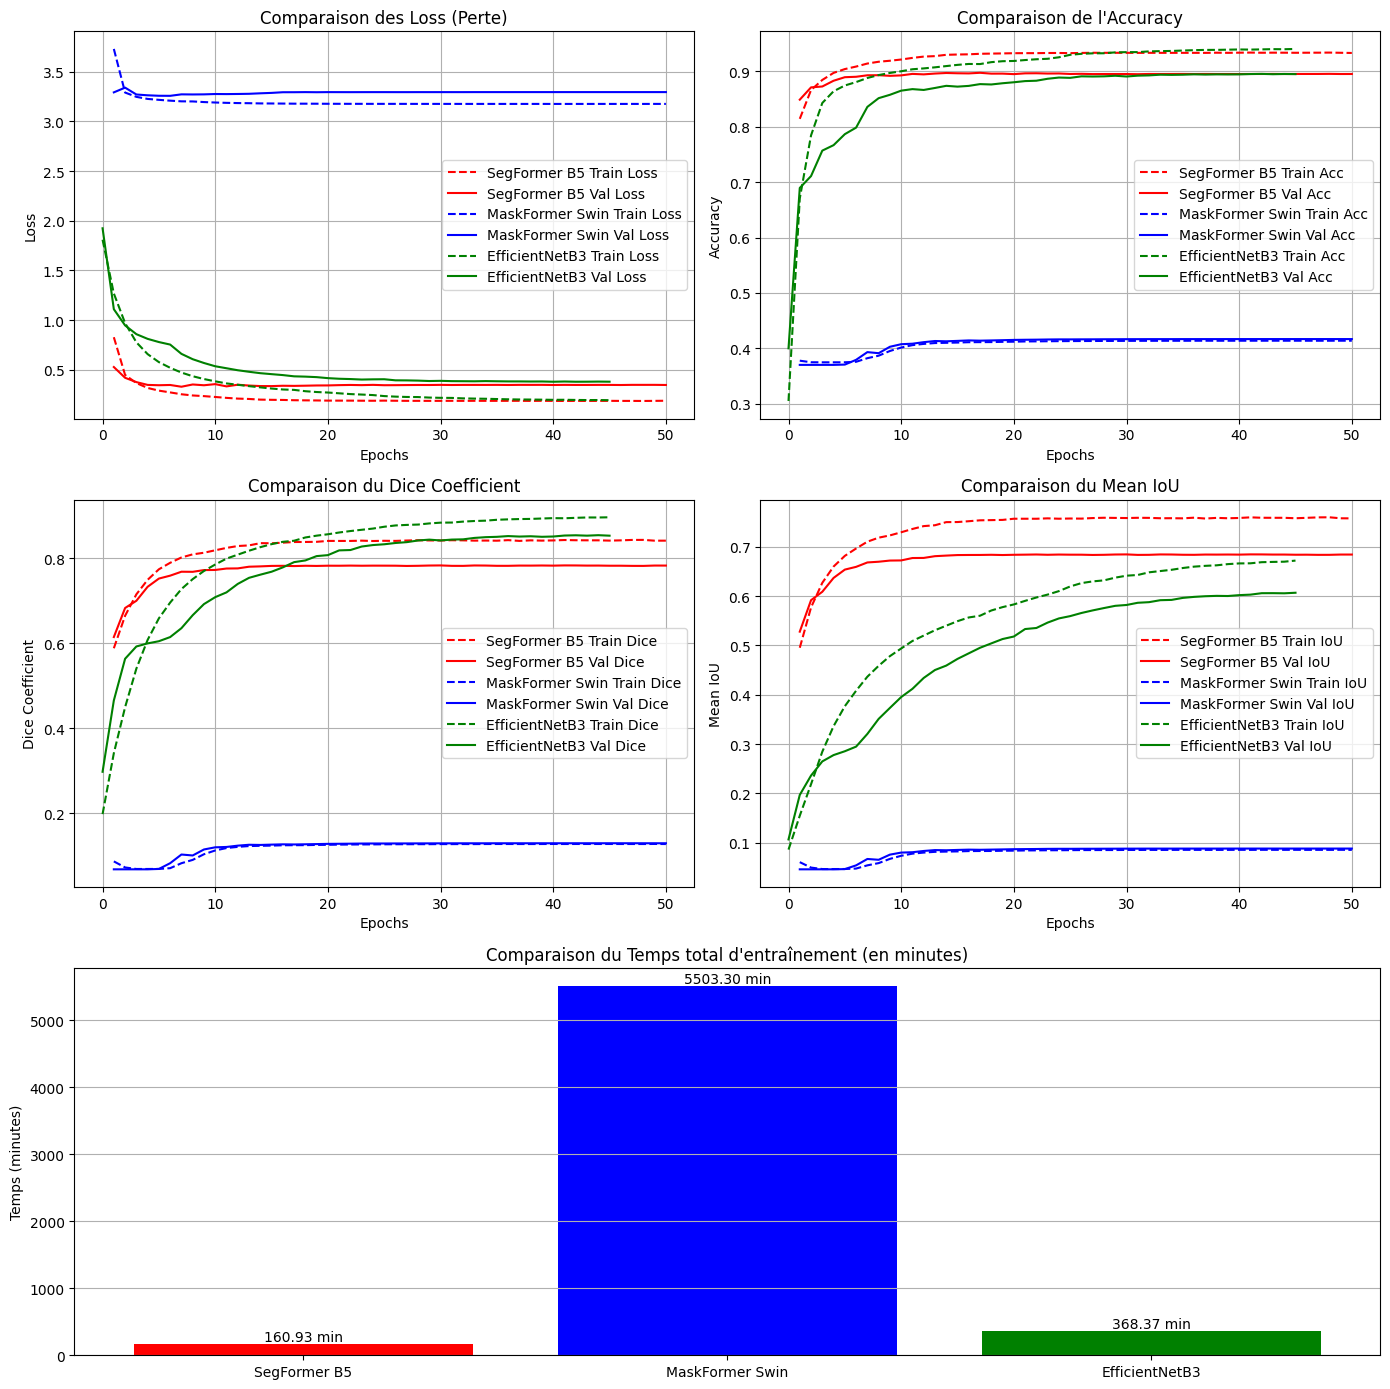

In [27]:
comparer_modeles(
    list_csv_files=[
        "../resultats_modeles/segformer_b5_log.csv",
        "../resultats_modeles/maskformer_swin_log.csv",
        "../resultats_modeles/efficientnetb3_log_renamed.csv"
    ],
    model_names=["SegFormer B5", "MaskFormer Swin", "EfficientNetB3"],
)

In [20]:
"""import torch
import torch.nn.functional as F
from glob import glob
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from fonctions import charger_segformer, remap_classes

############################################
# 1) Sélection des 3 premières images
############################################

DATA_DIR = Path("../data")
image_dir = DATA_DIR / "leftImg8bit" / "val"
mask_dir  = DATA_DIR / "gtFine"      / "val"

image_paths = sorted(glob(str(image_dir / "*/*.png")))
mask_paths  = sorted(glob(str(mask_dir  / "*/*labelIds.png")))

selected_images = image_paths[:3]
selected_masks  = mask_paths[:3]

print("Images sélectionnées :")
for p in selected_images:
    print(" -", p)
print("Masques sélectionnés :")
for m in selected_masks:
    print(" -", m)

############################################
# 2) Chargement du modèle SegFormer
############################################

model_segformer = charger_segformer(num_classes=8)
model_segformer.load_state_dict(
    torch.load("../resultats_modeles/segformer_b5.pth")
)
model_segformer.eval().cuda()  # on utilise le GPU si disponible

############################################
# 3) Fonctions utilitaires
############################################

def load_image_as_tensor(image_path, size=(256,256)):

    #Charge et redimensionne une image en PyTorch Tensor (3,H,W) normalisé [0..1].

    image = Image.open(image_path).convert("RGB").resize(size)
    import torchvision.transforms as T
    tensor_img = T.ToTensor()(image)  # shape (3,H,W)
    return tensor_img

def load_mask_as_np(mask_path, size=(256,256)):

    #Charge et redimensionne un masque labelIds,
    #puis applique le remapping vers 8 classes (void, flat, ...)
    #et retourne un numpy array (H,W).

    mask = Image.open(mask_path).convert("L").resize(size)
    mask_np = np.array(mask, dtype=np.uint8)
    mask_remapped = remap_classes(mask_np)
    return mask_remapped

def predict_segformer(model, image_tensor):

    #Fait une prédiction avec le modèle SegFormer déjà chargé.
    #Retourne un masque numpy (H,W) avec valeurs de 0 à 7.

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.unsqueeze(0).to(device)  # (1,3,H,W)
    with torch.no_grad():
        outputs = model(image_tensor)
        # Selon la version, la sortie peut être .logits ou dict["out"]
        if hasattr(outputs, "logits"):
            logits = outputs.logits
        else:
            logits = outputs["out"]

        # Upsample à la taille initiale
        logits = F.interpolate(
            logits,
            size=image_tensor.shape[-2:],  # (H,W)
            mode="bilinear",
            align_corners=False
        )
        pred = logits.argmax(dim=1).squeeze(0).cpu().numpy()
    return pred

############################################
# 4) Affichage des résultats
############################################

for i in range(3):
    img_path  = selected_images[i]
    mask_path = selected_masks[i]

    # Charger l'image et le masque
    image_t = load_image_as_tensor(img_path, size=(256,256))
    mask_np = load_mask_as_np(mask_path, size=(256,256))

    # Prédiction
    pred_segformer = predict_segformer(model_segformer, image_t)

    # Pour affichage
    image_np = np.array(Image.open(img_path).convert("RGB").resize((256,256)))

    # VISUALISATION
    plt.figure(figsize=(14,5))

    plt.subplot(1,3,1)
    plt.imshow(image_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(mask_np, cmap="magma", vmin=0, vmax=7)
    plt.title("Masque Réel (8 classes)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_segformer, cmap="magma", vmin=0, vmax=7)
    plt.title("Prédiction SegFormer B5")
    plt.axis("off")

    plt.tight_layout()
    plt.show()"""

'import torch\nimport torch.nn.functional as F\nfrom glob import glob\nfrom pathlib import Path\nfrom PIL import Image\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom fonctions import charger_segformer, remap_classes\n\n############################################\n# 1) Sélection des 3 premières images\n############################################\n\nDATA_DIR = Path("../data")\nimage_dir = DATA_DIR / "leftImg8bit" / "val"\nmask_dir  = DATA_DIR / "gtFine"      / "val"\n\nimage_paths = sorted(glob(str(image_dir / "*/*.png")))\nmask_paths  = sorted(glob(str(mask_dir  / "*/*labelIds.png")))\n\nselected_images = image_paths[:3]\nselected_masks  = mask_paths[:3]\n\nprint("Images sélectionnées :")\nfor p in selected_images:\n    print(" -", p)\nprint("Masques sélectionnés :")\nfor m in selected_masks:\n    print(" -", m)\n\n############################################\n# 2) Chargement du modèle SegFormer\n############################################\n\nmodel_segformer = charger_seg

In [21]:
"""from IPython.display import display, Image

images = [
    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_EfficienNetB3-1.png",
    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_SegFormerB5-1.png",
    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_EfficienNetB3-2.png",
    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_SegFormerB5-2.png",
    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_EfficienNetB3-3.png",
    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_SegFormerB5-3.png"
]

for img_path in images:
    display(Image(filename=img_path))"""

'from IPython.display import display, Image\n\nimages = [\n    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_EfficienNetB3-1.png",\n    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_SegFormerB5-1.png",\n    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_EfficienNetB3-2.png",\n    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_SegFormerB5-2.png",\n    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_EfficienNetB3-3.png",\n    "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv9/Predict_SegFormerB5-3.png"\n]\n\nfor img_path in images:\n    display(Image(filename=img_path))'

In [22]:
"""import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from fonctions import remap_classes

NUM_CLASSES = 8

def compute_class_distribution(mask_paths, n_samples=20):

    #Calcule le nombre total de pixels pour chaque classe (0..7)
    #sur un sous-ensemble 'n_samples' de masques.
    #Retourne un DataFrame {Classe, Pixels}.

    class_pixel_counts = np.zeros(NUM_CLASSES, dtype=np.uint64)

    subset_paths = mask_paths[:n_samples]
    for path in tqdm(subset_paths, desc="Calcul distribution"):
        mask_pil = Image.open(path).convert("L")
        mask_np = np.array(mask_pil, dtype=np.uint8)

        # Remap Cityscapes -> [0..7]
        mask_remapped = remap_classes(mask_np)

        # Comptage
        for c in range(NUM_CLASSES):
            class_pixel_counts[c] += np.count_nonzero(mask_remapped == c)

    df = pd.DataFrame({
        "Classe": range(NUM_CLASSES),
        "Pixels": class_pixel_counts
    })
    return df

# Choisir un sous-ensemble pour ne pas trop alourdir le calcul
df_dist = compute_class_distribution(train_mask_paths, n_samples=20)

# Afficher un aperçu
display(df_dist)

# Sauvegarder le CSV
df_dist.to_csv("distribution_classes.csv", index=False)"""

'import numpy as np\nimport pandas as pd\nfrom PIL import Image\nfrom tqdm import tqdm\nfrom fonctions import remap_classes\n\nNUM_CLASSES = 8\n\ndef compute_class_distribution(mask_paths, n_samples=20):\n\n    #Calcule le nombre total de pixels pour chaque classe (0..7)\n    #sur un sous-ensemble \'n_samples\' de masques.\n    #Retourne un DataFrame {Classe, Pixels}.\n\n    class_pixel_counts = np.zeros(NUM_CLASSES, dtype=np.uint64)\n\n    subset_paths = mask_paths[:n_samples]\n    for path in tqdm(subset_paths, desc="Calcul distribution"):\n        mask_pil = Image.open(path).convert("L")\n        mask_np = np.array(mask_pil, dtype=np.uint8)\n\n        # Remap Cityscapes -> [0..7]\n        mask_remapped = remap_classes(mask_np)\n\n        # Comptage\n        for c in range(NUM_CLASSES):\n            class_pixel_counts[c] += np.count_nonzero(mask_remapped == c)\n\n    df = pd.DataFrame({\n        "Classe": range(NUM_CLASSES),\n        "Pixels": class_pixel_counts\n    })\n    return d

In [23]:
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

from fonctions import remap_classes

DATA_DIR = Path("../data")
image_dir = DATA_DIR / "leftImg8bit"
mask_dir  = DATA_DIR / "gtFine"

train_input_img_paths = sorted(glob(str(image_dir / "train/*/*.png")))
train_label_ids_img_paths = sorted(glob(str(mask_dir  / "train/*/*labelIds.png")))

val_input_img_paths = sorted(glob(str(image_dir / "val/*/*.png")))
val_label_ids_img_paths = sorted(glob(str(mask_dir  / "val/*/*labelIds.png")))

# Subset
train_img_paths = train_input_img_paths[:2000]
train_mask_paths = train_label_ids_img_paths[:2000]

val_img_paths = val_input_img_paths[:500]
val_mask_paths = val_label_ids_img_paths[:500]

In [24]:
def compute_pixel_distribution_for_one_mask(mask_path: str, remap_func, num_classes=8) -> list:
    """
    Ouvre un masque Cityscapes, applique le remapping (0..33 -> 0..7),
    et retourne un tableau [count0, count1, ..., count7].
    """
    mask_pil = Image.open(mask_path).convert("L")
    mask_np = np.array(mask_pil, dtype=np.uint8)
    mask_remapped = remap_func(mask_np)  # ex.: remap_classes
    counts = [(mask_remapped == c).sum() for c in range(num_classes)]
    return counts

In [25]:
"""def build_cityscapes_csv(
    img_paths,
    mask_paths,
    split_label,
    remap_func,
    num_classes=8
):

    # Construit un DataFrame pour un ensemble (train ou val).
    # Col: [image_path, mask_path, split, px_class0..px_class7].

    data_rows = []
    for img_path, msk_path in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc=f"Processing {split_label}"):
        dist = compute_pixel_distribution_for_one_mask(msk_path, remap_func, num_classes=num_classes)
        row = {
            "image_path": img_path,
            "mask_path": msk_path,
            "split": split_label
        }
        # Ajouter px_class0..px_class7
        for c in range(num_classes):
            row[f"px_class{c}"] = dist[c]
        data_rows.append(row)
    df = pd.DataFrame(data_rows)
    return df

# Construire DF pour train
df_train = build_cityscapes_csv(
    train_img_paths,
    train_mask_paths,
    split_label="train",
    remap_func=remap_classes
)

# Construire DF pour val
df_val = build_cityscapes_csv(
    val_img_paths,
    val_mask_paths,
    split_label="val",
    remap_func=remap_classes
)

# Concaténer
df_all = pd.concat([df_train, df_val], ignore_index=True)

print(df_all.head())

# Sauvegarder
df_all.to_csv("cityscapes_subset.csv", index=False)
print("Fichier cityscapes_subset.csv généré avec succès!")"""

'def build_cityscapes_csv(\n    img_paths,\n    mask_paths,\n    split_label,\n    remap_func,\n    num_classes=8\n):\n\n    # Construit un DataFrame pour un ensemble (train ou val).\n    # Col: [image_path, mask_path, split, px_class0..px_class7].\n\n    data_rows = []\n    for img_path, msk_path in tqdm(zip(img_paths, mask_paths), total=len(img_paths), desc=f"Processing {split_label}"):\n        dist = compute_pixel_distribution_for_one_mask(msk_path, remap_func, num_classes=num_classes)\n        row = {\n            "image_path": img_path,\n            "mask_path": msk_path,\n            "split": split_label\n        }\n        # Ajouter px_class0..px_class7\n        for c in range(num_classes):\n            row[f"px_class{c}"] = dist[c]\n        data_rows.append(row)\n    df = pd.DataFrame(data_rows)\n    return df\n\n# Construire DF pour train\ndf_train = build_cityscapes_csv(\n    train_img_paths,\n    train_mask_paths,\n    split_label="train",\n    remap_func=remap_classes\n)\n